In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Data processing, modeling, and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix

# Randomization
import random

#Files
import h5py
import glob
import seaborn as sns

In [2]:
f=h5py.File(r'features_database_gait_one_cycles_both_legs.h5', 'r')
print(list(f.keys()))
x = f['right'][:,:,:]
print('(samples, timesteps, features)', x.shape)


['left', 'right']
(samples, timesteps, features) (56, 132, 7)


In [3]:
path = f'cut_one_gait_cycle_right'
filelist =[]
digits =[]
digits_int =[]
for file in glob.glob(f'{path}\\*.c3d',recursive = True):
    filelist.append(file[4:-4].replace("_", ""))
    digits.append(file[25:-9])

for ele in digits:
    digits_int.append(1) if ele=='degeneration' else digits_int.append(0)

In [4]:
nsamples, nx, ny = x.shape
d2_x = x.reshape((nsamples,nx*ny))

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(d2_x)
scaled_data

array([[-0.78587596, -0.82317414, -0.57757494, ...,  0.17063314,
        -1.53469349, -0.02270415],
       [-1.18446787, -0.52566653, -0.33943407, ..., -0.18203577,
        -0.72926615, -1.4792172 ],
       [-0.71469326, -0.81458604, -0.65046515, ..., -0.33951045,
         0.31651781, -0.22409644],
       ...,
       [ 0.65413661, -0.9052287 , -0.74884184, ..., -0.50387479,
         0.1772907 , -0.47810273],
       [ 1.30308212, -0.97879991, -1.14980435, ...,  0.77758619,
         1.17631905,  1.30447965],
       [ 1.30308212, -0.97879991, -1.14980435, ...,  0.77758619,
         1.17631905,  1.30447965]])

In [6]:
components = min(56, 7)
pca = PCA(n_components=components, svd_solver='full')
pca.fit(scaled_data)
X_pca = pca.transform(scaled_data)

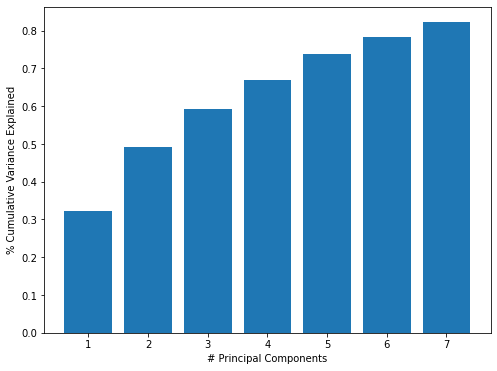

In [7]:
# Calculate cumulative explained variance across all PCs

cum_exp_var = []
var_exp = 0
for i in pca.explained_variance_ratio_:
    var_exp += i
    cum_exp_var.append(var_exp)

# # Plot cumulative explained variance for all PCs

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,8), cum_exp_var)
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained');

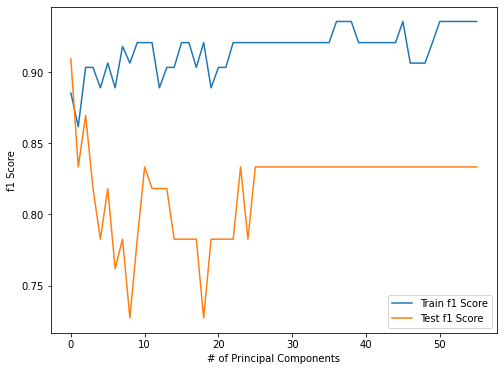

In [11]:
train_f1 = []
test_f1 = []

for i in range(56):
    
    X = scaled_data[:,0:i+1]
    
    # Train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X, digits_int,
                                                        test_size=0.25,
                                                        random_state=42)

    # Perform feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit k-NN classifier and make predictions
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)
    train_f1.append(f1_score(y_train, y_pred_train))
    test_f1.append(f1_score(y_test, y_pred_test))

# Plot accuracy by n_neighbors
plt.figure(figsize=(8, 6))
plt.plot(range(0,56), train_f1, label='Train f1 Score')
plt.plot(range(0,56), test_f1, label='Test f1 Score')
plt.ylabel('f1 Score')
plt.xlabel('# of Principal Components')
plt.legend()
plt.show()

In [12]:
X = scaled_data[:,0:4]
    
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, digits_int,
                                                    test_size=0.25,
                                                    random_state=42)

# Perform feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit k-NN classifier and make predictions
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)
    
print(f'Train f1 Score: {f1_score(y_train, y_pred_train)}')
print(f'Test f1 Score: {f1_score(y_test, y_pred_test)}')
print(classification_report(y_test, y_pred_test))

Train f1 Score: 0.9032258064516129
Test f1 Score: 0.8181818181818182
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.82      0.82      0.82        11

    accuracy                           0.71        14
   macro avg       0.58      0.58      0.58        14
weighted avg       0.71      0.71      0.71        14



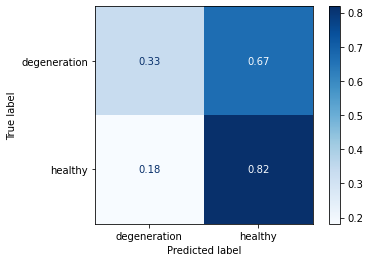

In [14]:
plot_confusion_matrix(knn, X_test, y_test, display_labels=['degeneration',
                                                          'healthy'],
                     normalize='true', cmap='Blues');